In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.cluster import KMeans
from collections import Counter
import umap


In [2]:
class Profile():
    def __init__(self, filename):
        self._metadata = {}
        self._projects = {}
        self._votes = {}
        with open(filename, "r", encoding="utf8") as self.file:
            self.__read_lines()

        self.__convert_projects()
        self.__convert_votes()
        
    @property
    def ballots(self):
        return self._ballots
        
    def __convert_projects(self):
        self._projectid_to_index = {}
        tmp = {}
        for i, (proj_id, budget) in enumerate(self._projects.items()):
            self._projectid_to_index[proj_id] = i
            tmp[i] = budget
        self._projects = tmp
        
    def __convert_votes(self):
        self._votes = [np.array([self._projectid_to_index[x]]) if isinstance(x, int) else np.array([self._projectid_to_index[int(y)] for y in x.split(",")]) for x in self._votes.values()]
        self._ballots = np.zeros((self._metadata["num_votes"], self._metadata["num_projects"]))
        for i, vote in enumerate(self._votes):
            self._ballots[i,vote] = 1
       
    def __read_lines(self):
        _sections = {"META":self._metadata, 
                     "PROJECTS":self._projects, 
                     "VOTES":self._votes}
        _slices = {"key":"value",
                   "project_id":"cost",
                   "voter_id":"vote"}
        
        for line in self.file:
            line = line.strip()

            items = line.split(";")
            # find the right index for one of the properties (value, cost, vote)
            try:
                index = items.index(_slices[items[0]])
            except KeyError:
                pass
            else:
                continue 
            
            # switch to a new dict when a new section is found
            try: 
                _current = _sections[line]
            except KeyError:
                pass
            else:
                continue
            
            # read data
            try:
                try:
                    key = int(items[0])
                except ValueError:
                    key = items[0]
                _current[key] = int(items[index])
            except IndexError:
                pass
            except ValueError:
                _current[key] = items[index]

In [3]:
with open("data//sorted_files.pkl", 'rb') as f:
    file_division = pickle.load(f)

In [4]:
approval_profile_files = sorted(file_division['approval'], key=lambda x: x[1], reverse=True)

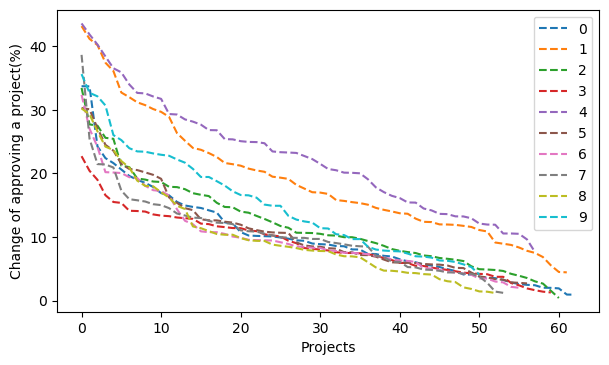

In [5]:
rcParams['figure.figsize'] = 7, 4
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 10})
for i in range(10):
    x = Profile(approval_profile_files[i][0])
    plt.plot(x.ballots.mean(0)*100,'--',label=i)
plt.legend()
plt.xlabel("Projects")
plt.ylabel("Change of approving a project(%)")
plt.show()

In [6]:
i = 7
data = Profile(approval_profile_files[i][0]).ballots
n_clusters = 9

# k = KMeans(n_clusters).fit(data)

In [7]:
reducer = umap.UMAP(n_components=2, n_neighbors=50, metric='manhattan')
reducer.fit(data)
embedding = reducer.transform(data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(3553, 2)

Text(0.5, 1.0, 'UMAP projection of the dataset')

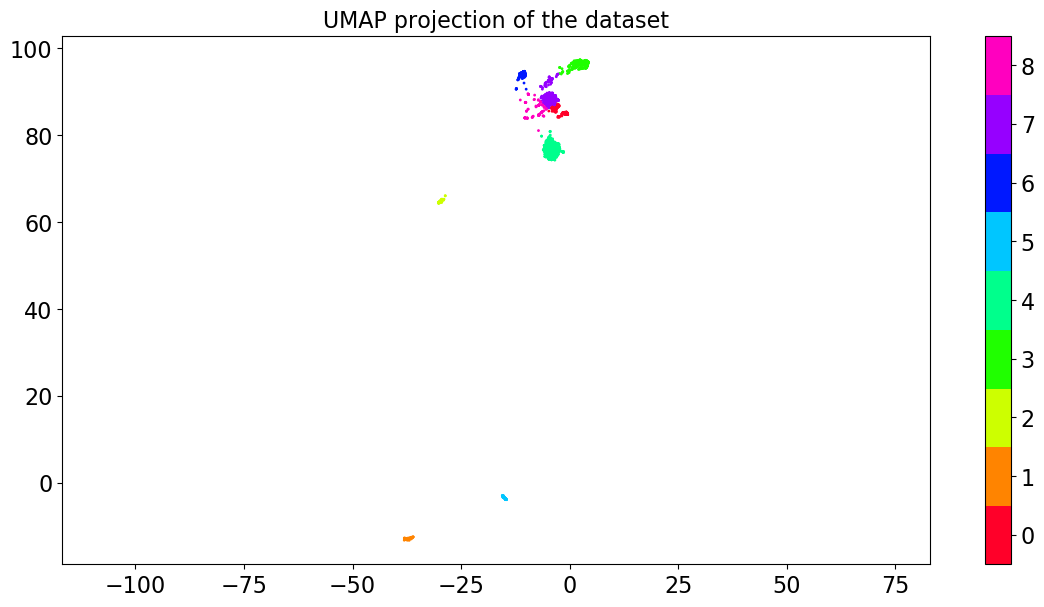

In [8]:
k = KMeans(n_clusters).fit(embedding)

rcParams['figure.figsize'] = 14, 7
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=k.labels_, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(n_clusters+1)-0.5).set_ticks(np.arange(n_clusters))
plt.title('UMAP projection of the dataset', fontsize=16)

In [9]:
print(f"number of approvals per cluster: {np.sum(cluster_mean, 1)}")

cluster_size = Counter(k.labels_) 

distance = {i:{} for i in range(n_clusters)}
for c, ballot in zip(k.labels_, embedding):
    dis = int(np.abs(ballot - k.cluster_centers_[c]).sum())
    try:
        distance[c][dis] += 1/cluster_size[c]
    except KeyError:
        distance[c][dis] = 1/cluster_size[c]
        
for c, dist in distance.items():
    plt.plot(*zip(*sorted(dist.items())), label=c)
plt.legend()
plt.show()

NameError: name 'cluster_mean' is not defined